In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,Birch
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import silhouette_score

/home/piotr/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Wczytanie danych

In [3]:

labels = pd.read_fwf("./UCI_HAR_Dataset/features.txt",header=None)
X_train = pd.read_fwf("./UCI_HAR_Dataset/train/X_train.txt",header=None)
X_train.columns = labels


y_train = pd.read_fwf("./UCI_HAR_Dataset/train/y_train.txt",header=None)
y_train = pd.Series(y_train[0])

X_test = pd.read_fwf("./UCI_HAR_Dataset/test/X_test.txt",header=None)
X_test.columns = labels

y_test = pd.read_fwf("./UCI_HAR_Dataset/test/y_test.txt",header=None)
y_test = pd.Series(y_test[0])

data = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])


In [4]:
proper = list()
for i in range(len(data.columns)):
    proper.append(data.columns[i][0])  
data.columns = proper

data.reset_index(inplace=True,drop=True)

In [5]:
data.shape

(10299, 561)

## Ilość klastrów

Z etykiet wiemy że mamy 6 klastrów, ale sprawdźmy dla jakiej ilości klastrów metoda sillhoute da najlepszy wynik.

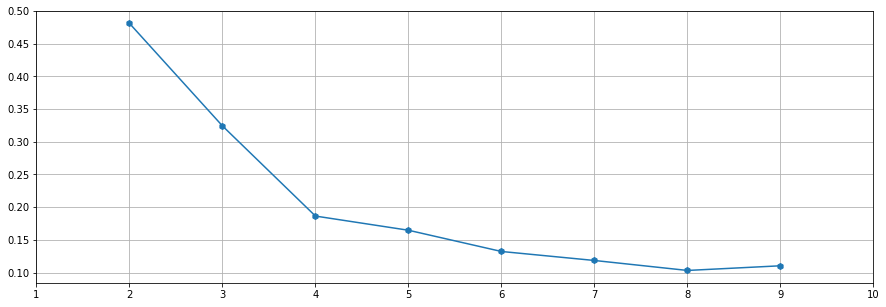

In [17]:
scors = []
for k in range(2, 10):
    met = KMeans(k)
    label = met.fit_predict(data)
    scors.append(silhouette_score(data,label))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), scors,marker='h')
plt.xticks(np.arange(1,11, 1))
plt.grid(True)



## Baseline

Jako punkt odniesniesienia do wszelkich następnych prób sprawdźmy jak poradzą sobie podstawowe algorytmy na nieprzekstałconym zbiorze danych.

In [31]:
kmean = KMeans(k)
yhat = kmean.fit_predict(data)
silhouette_score(data,yhat)

0.0694467809984462

In [32]:
ac = AgglomerativeClustering(k)
yhat = ac.fit_predict(data) 
silhouette_score(data,yhat)

0.05645208265480925

In [34]:
bir = Birch(n_clusters = k)
yhat = bir.fit_predict(data) 
silhouette_score(data,yhat)

0.05645208265480925

Jak widać wyniki osiągane przez algorytmy nie są najlepsze, czemu z pewnością nie sprzyaja szum tworzony przez sporą ilość kolumn, przez co cięzko o dobrze zdefiniowane klastry.

# Feature engineering

Biorąc pod uwagę z jak dużą ilościa kolumn mamy do czynienia nie ma mowy o ręcznym wybieraniu cech, musimy się posiłkować odpowiednimi algorytmami.

In [26]:
pca = PCA(n_components=100)
pca_data = pca.fit_transform(data)
cum_ratio = (np.cumsum(pca.explained_variance_ratio_))

variance_ratio = 0.80
variance = np.cumsum(pca.explained_variance_ratio_)
num = np.sum(variance<variance_ratio)+1
print(f'{variance_ratio} % wariancji jest przestawiane przez {num} zmiennych')

0.8 % wariancji jest przestawiane przez 11 zmiennych


In [12]:
pca = PCA(n_components=11)
pca_data = pca.fit_transform(data)

Text(0, 0.5, 'Sillhoute score')

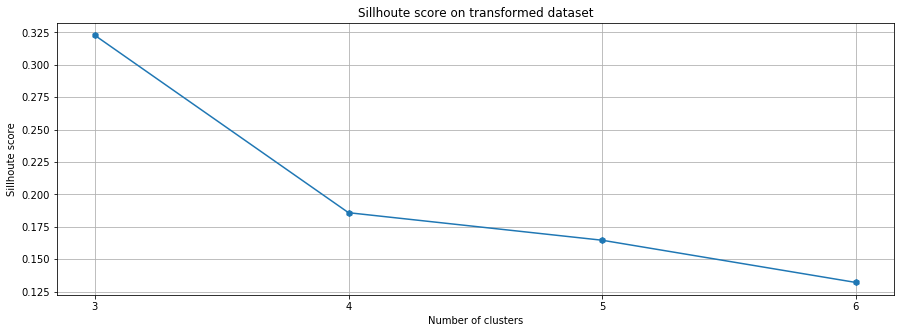

In [14]:
scors = []
for k in range(3,7):
    kmean = KMeans(k)
    yhat = kmean.fit_predict(pca_data)
    scors.append(silhouette_score(data,yhat))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(3, 7), scors,marker='h')
plt.xticks(np.arange(3,7,1))
plt.grid(True)
plt.title('Sillhoute score on PCA transformed dataset')
plt.xlabel('Number of clusters')
plt.ylabel('Sillhoute score')

Całkiem dobry wynik dla k=3.

In [ ]:

pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_data)
scors = []
for k in range(3,7):
    kmean = KMeans(k)
    yhat = kmean.fit_predict(tsne_transformed)
    scors.append(silhouette_score(data,yhat))


Text(0, 0.5, 'Sillhoute score')

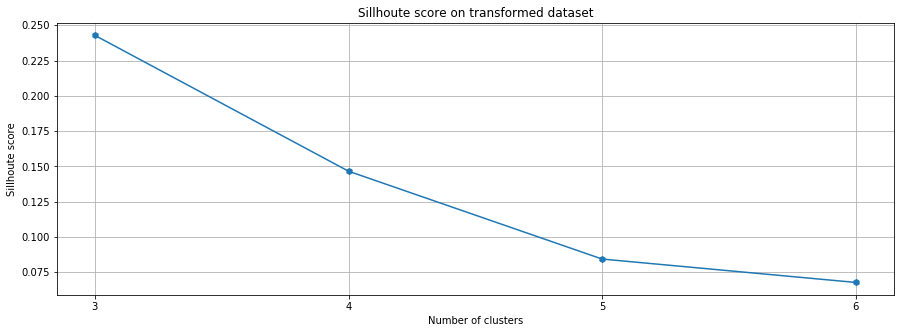

In [16]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(3, 7), scors,marker='h')
plt.xticks(np.arange(3,7,1))
plt.grid(True)
plt.title('Sillhoute score on Tsne transformed dataset')
plt.xlabel('Number of clusters')
plt.ylabel('Sillhoute score')


## Usuwanie zmiennych z niską wariancją

Kolejną metoda z której zdecydujemy się skorzystać będzie Variance Threshold

In [48]:
selector = VarianceThreshold(0.05)
X_new = selector.fit_transform(data)

In [49]:
kmean = KMeans(6)
yhat = kmean.fit_predict(X_new)
silhouette_score(data,yhat)

0.06027302691693993

## Funkcje pomocniczne

In [6]:
def score_kmeans(df, cluster_num_vector):
    """
    Funkcja zwraca miary wcss odpowiadające wartością k,
    działa dla modelu k-średnich.
    """
    scores = []
    for k in cluster_num_vector:
        md = KMeans(n_clusters = k)
        md.fit(df)
        scr = md.score(df)
        scores.append(-scr)
    return(scores)

In [7]:
def plot_k_scores(k_vec, result, xlab, ylab, title):
    """Wizualizacja dowolnej miary względem dowolnego wektora k."""
    plt.plot(k_vec, result, marker='h')
    plt.xticks(np.arange(min(k_vec), max(k_vec)+1, 2))
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [8]:
def find_best_k(df, k_vec):
    scr = score_kmeans(df, k_vec)
    plot_k_scores(k_vec, scr, "k", "wcss", "Poszukiwanie optymalnego 'k'")

## 2. Factor Analysis
Metoda statystyczna, której celem jest opisanie zależności między zaobserwowanymi, skorelowanymi zmiennymi przy pomocy możliwie mniejszej liczby zmiennych nieobserwowanych nazywanych czynnikami bądź faktorami, które są wzajemnie nieskorelowane.

In [9]:
#%pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

### Kaiser-Meyer-Olkin test
Test ten mierzy czy zbiór danych jest odpowiedni do przeprowadzenia analizy czynnikowej (factor analysis). KMO przyjmuje wartości od 0 do 1. Wartość powyżej 0.6 oznacza adekwatność użycia metody analizy czynnikowej.

In [11]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(data)
print("Wartość KMO dla naszych danych: {0:4.3f}".format(kmo_model))

Wartość KMO dla naszych danych: 0.979


Jak widzimy nasz zbiór jest perfekcyjnym przypadkiem do analizy czynnikowej.

### Analiza czynnikowa 

In [12]:
#Wykonanie analizy czynnikowej
factor_analyzer = FactorAnalyzer(rotation=None, n_factors=561)
factor_analyzer.fit(data)

#Wartości własne
wartosci_wlasne, wektory = factor_analyzer.get_eigenvalues() 

Jedną z metod wyboru odpowiedniej liczby czynników, jest wybór tych z nich, dla których odpowiadające wartości własne są większe niż 1. Dla naszego zbioru będzie to 63 czynniki. Uzyskujemy więc redukcję liczby zmiennych z 561 do 63.

In [13]:
num_factors = len(wartosci_wlasne[wartosci_wlasne>1])
num_factors

63

Dla mniejszych zbiorów można dokonać doboru liczby czynników metodą graficzną, podobną do metody "łokcia". W naszym przypadku, ciężko jest jednak zastosować tę metodę, gdyż wykres staje się nieczytelny. 

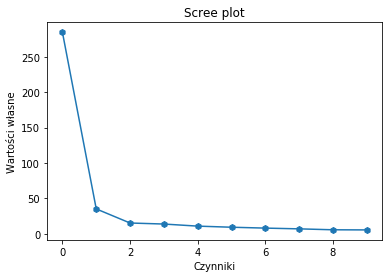

In [14]:
plot_k_scores(range(10), wartosci_wlasne[0:10], "Czynniki", "Wartości własne", "Scree plot")

In [15]:
#Analiza dla dobranej liczby czynników
fa = FactorAnalyzer(n_factors=num_factors)
fa.fit(data)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=63, rotation='promax',
               rotation_kwargs={}, use_smc=True)

In [16]:
#Zbiór danych po transformacji analizy czynników
df2 = fa.transform(data)
df2 = pd.DataFrame(df2)

In [17]:
print("Wymiary zbioru danych po transformacji nr 2:")
print(df2.shape)

Wymiary zbioru danych po transformacji nr 2:
(10299, 63)


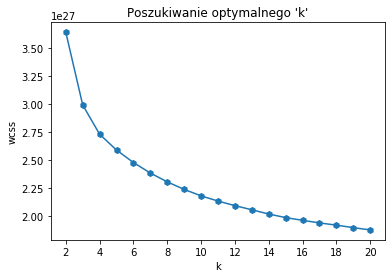

In [18]:
find_best_k(df2, range(2, 21))

In [19]:
#Zapis do pliku df2, aby uniknąć czasochłonnych obliczeń
df2.to_csv("df2.csv")

## 4. Usunięcie wysoko skorelowanych zmiennych

W naszym zbiorze danych jest wiele zmiennych bardzo mocno skorelowanych. Rozsądnym podejściem wydaje się próba usunięcia ich ze zbioru. Zdecydowaliśmy się usunąć zmienne o współczynniku korelacji większym niż 0.8.

In [21]:
def remove_corr(dataset, threshold):
    #Zbiór nazw usuniętych kolumn
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                #nazwa kolumny
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
                if colname in dataset.columns:
                    #usunięcie kolumny
                    del dataset[colname]
    return(dataset)

In [27]:
df4 = data.copy()
df4 = remove_corr(df4, 0.9)

In [93]:
print("Wymiary zbioru danych po transformacji nr 4:")
df4.shape

Wymiary zbioru danych po transformacji nr 4:


(10299, 198)

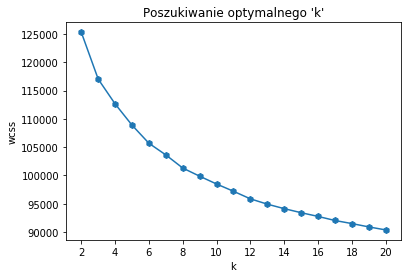

In [132]:
find_best_k(df4, range(2, 21))

## 5. Tylko zmienne po transformacie Furiera
EDA pokazała, że transformata Furiera poprawiała separowalność klas w przypadkach możliwych do analizy wizualnej. Z tego powodu postanowiliśmy przetestować podejście, polegające na pozostawieniu w zbiorze tylko tych zmiennych, które zostały przez autorów zbioru danych (badania) poddane transformacie Furiera.

In [23]:
df5 = data.iloc[:, 266:]

In [160]:
print("Wymiary zbioru danych po transformacji nr 5:")
df5.shape

Wymiary zbioru danych po transformacji nr 5:


(10299, 295)

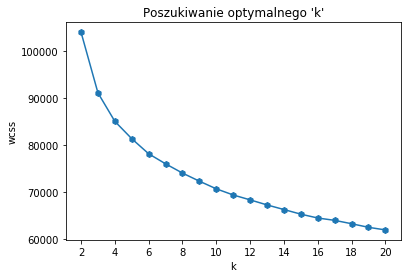

In [133]:
find_best_k(df5, range(2, 21))

# Modelowanie

In [8]:
def score_clustering(df, model, k_vec, score_fun):
    """
    Oblicza miary, za pomocą przekazanej funkcji miay, 
    względem k, a także przekazanego modelu.
    """
    scores=[]
    for k in k_vec:
        md = model(n_clusters=k)
        labels = md.fit_predict(df)
        score = score_fun(df, labels)
        scores.append(score)
    return(scores)

In [24]:
datasets = {"orginal": data,
            "df2": df2, 
            "df4": df4, 
            "df5": df5}

models = {"kmeans": KMeans, 
          "agg": AgglomerativeClustering,
          "birch": Birch}

optimal_k = {"orginal": 10,
            "df2": 10,
            "df4": 10,
            "df5": 10}

def research(datasets, models, optimal_k, score_fun):
    results = pd.DataFrame()

    for df_k in datasets:
        for model_k in models:
            md = models[model_k]()
            df = datasets[df_k]
            k = optimal_k[df_k]
            
            md.n_clusters = k
            labels = md.fit_predict(X = df)
            score = score_fun(df, labels)
            results.loc[df_k, model_k] = score
            
            #temp
            print(df_k + model_k)
    return(results)

## Wyniki: miara silhouette

In [28]:
silhouette_results = research(datasets, models, optimal_k, silhouette_score)

orginalkmeans
orginalagg
orginalbirch
df2kmeans
df2agg
df2birch
df4kmeans
df4agg
df4birch
df5kmeans
df5agg
df5birch


In [29]:
silhouette_results

,kmeans,agg,birch
orginal,0.103869,0.067926,0.067926
df2,0.097242,0.076751,0.076751
df4,0.070604,0.042015,0.042015
df5,0.097150,0.081899,0.080944


In [30]:
from scipy.spatial import distance

def avg_dist_score(df, labels):
    """Oblicza miarę średniej odległości wewnątrz klastra"""
    distances = []
    for lab in labels:
        X = df.iloc[np.where(labels == lab)]
        dist_avg = np.mean(distance.pdist(X))
        distances.append(dist_avg)
    return np.mean(distances)

In [ ]:
avg_dist_results = research(datasets, models, optimal_k, avg_dist_score)